In [1]:
from erddapy import ERDDAP
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime, timedelta
import os
import time
from dateutil.relativedelta import relativedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
def download_oisst_data_griddap(start_date, end_date, min_lat, max_lat, min_lon, max_lon):
    from erddapy import ERDDAP
    import xarray as xr

    e = ERDDAP(
        server="https://coastwatch.pfeg.noaa.gov/erddap/",
        protocol="griddap",
    )
    e.dataset_id = "nesdisGeoPolarSSTN5NRT_Lon0360"
    
    # Initialize dataset metadata
    e.griddap_initialize()
    
    # Update constraints based on your specific request
    # Make sure to only adjust the values of existing keys
    e.constraints['time>='] = start_date
    e.constraints['time<='] = end_date
    e.constraints['latitude>='] = min_lat
    e.constraints['latitude<='] = max_lat
    e.constraints['longitude>='] = min_lon
    e.constraints['longitude<='] = max_lon

    # Specify variables you're interested in
    # Assuming you want Sea Surface Temperature ('sst') data
    e.variables = ["sst"]
    
    # Attempt to fetch the data as an xarray Dataset
    try:
        ds = e.to_xarray()
        return ds
    except Exception as ex:
        print(f"An error occurred: {ex}")
        return None

In [3]:
# Define your date range and geographic bounds for the area of interest
start_date = "2002-09-01T00:00:00Z"
end_date = "2024-04-23T12:00:00Z"
min_lat = 0  # Southern tip, including much of the Indian Ocean
max_lat = 25   # Northern limit, covering the Bay of Bengal and Arabian Sea
min_lon = 60   # Western limit, near the African coast
max_lon = 100  # Eastern limit, up to the western edge of Australia
batch_size_years = 1  # You may adjust this size as needed

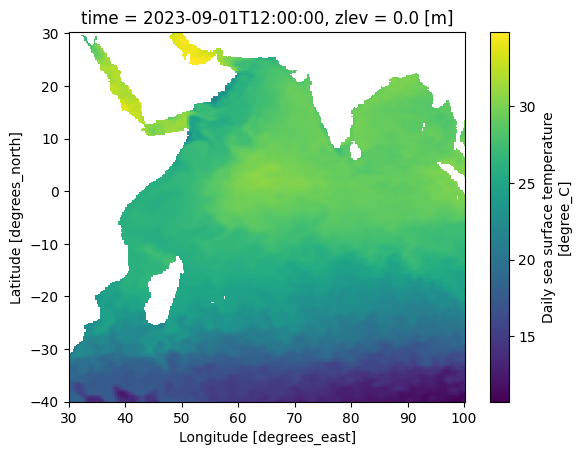

In [55]:
# Call the function
ds = download_oisst_data_griddap(start_date, end_date, min_lat, max_lat, min_lon, max_lon)

if ds is not None:
    # Example of how to visualize one time step of the SST data
    import matplotlib.pyplot as plt
    ds['sst'].isel(time=0).plot()
    plt.show()

In [2]:
def generate_date_ranges(start_date, end_date, batch_size_months):
    """Generate date ranges for each batch with a specified batch size in months."""
    ranges = []
    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = min(current_start_date + relativedelta(months=batch_size_months), end_date)
        ranges.append((current_start_date, current_end_date))
        current_start_date = current_end_date
    return ranges

In [3]:
def download_data_for_range(start_date, end_date, min_lat, max_lat, min_lon, max_lon, save_path):
    e = ERDDAP(
        server="https://coastwatch.pfeg.noaa.gov/erddap/",
        protocol="griddap",
    )
    e.dataset_id = "nesdisGeoPolarSSTN5NRT_Lon0360"
    
    e.griddap_initialize()
    
    e.constraints['time>='] = start_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    e.constraints['time<='] = end_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    e.constraints['latitude>='] = min_lat
    e.constraints['latitude<='] = max_lat
    e.constraints['longitude>='] = min_lon
    e.constraints['longitude<='] = max_lon

    e.variables = ["analysed_sst"]
    
    try:
        ds = e.to_xarray()
        file_name = f"oisst_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}.nc"
        file_path = os.path.join(save_path, file_name)
        ds.to_netcdf(file_path)
        print(f"Saved batch: {file_path}")
        return file_path
    except Exception as ex:
        print(f"An error occurred while downloading: {ex}")
        return None

In [19]:
# Define the date range for the area of interest
start_date = datetime(2023, 10, 1)
end_date = datetime(2024, 4, 23)

# Directory to save the NetCDF files
save_path = "/Users/samagra/INCOIS/GHRSST"
os.makedirs(save_path, exist_ok=True)

In [20]:
# Generate the DataFrame with the date ranges
date_ranges = generate_date_ranges(start_date, end_date, 1)

In [21]:
file_paths = []
for start_date, end_date in date_ranges:
    file_path = download_data_for_range(start_date, end_date, 0, 25, 60, 100, save_path)
    if file_path:
        file_paths.append(file_path)
    time.sleep(1)  # Sleep between downloads to not overwhelm the server

Saved batch: /Users/samagra/INCOIS/GHRSST/oisst_20231001_20231101.nc
Saved batch: /Users/samagra/INCOIS/GHRSST/oisst_20231101_20231201.nc
Saved batch: /Users/samagra/INCOIS/GHRSST/oisst_20231201_20240101.nc
Saved batch: /Users/samagra/INCOIS/GHRSST/oisst_20240101_20240201.nc
Saved batch: /Users/samagra/INCOIS/GHRSST/oisst_20240201_20240301.nc
Saved batch: /Users/samagra/INCOIS/GHRSST/oisst_20240301_20240401.nc
Saved batch: /Users/samagra/INCOIS/GHRSST/oisst_20240401_20240423.nc


In [82]:
# Combine all the individual files
datasets = [xr.open_dataset(os.path.join(save_path, fn)) for fn in file_names]
combined_ds = xr.concat(datasets, dim="time")
combined_file_name = "/mnt/data/combined_oisst_data.nc"
combined_ds.to_netcdf(combined_file_name)
print(f"Combined dataset saved as {combined_file_name}")

ValueError: must supply at least one object to concatenate

An error occurred while downloading: The read operation timed out
Attempt 1 failed, retrying after 10 seconds...
An error occurred while downloading: The read operation timed out
Attempt 1 failed, retrying after 10 seconds...
An error occurred while downloading: The read operation timed out
Attempt 1 failed, retrying after 10 seconds...
An error occurred while downloading: The read operation timed out
Attempt 3 failed, retrying after 10 seconds...
An error occurred while downloading: The read operation timed out
Attempt 1 failed, retrying after 10 seconds...
An error occurred while downloading: The read operation timed out
Attempt 1 failed, retrying after 10 seconds...
Failed to download after all retries.
An error occurred while downloading: The read operation timed out
Attempt 2 failed, retrying after 10 seconds...


In [ ]:
# An example plot from the combined dataset
combined_ds.sst.isel(time=0).plot()
plt.show()

In [71]:
import xarray as xr

# Replace 'your_file.nc' with the path to one of your NetCDF files
ds = xr.open_dataset('/Users/samagra/INCOIS/SST 1981/oisst_19810101_19881231.nc')
print(ds.time)


<xarray.DataArray 'time' (time: 122)> Size: 976B
array(['2023-09-01T12:00:00.000000000', '2023-09-02T12:00:00.000000000',
       '2023-09-03T12:00:00.000000000', '2023-09-04T12:00:00.000000000',
       '2023-09-05T12:00:00.000000000', '2023-09-06T12:00:00.000000000',
       '2023-09-07T12:00:00.000000000', '2023-09-08T12:00:00.000000000',
       '2023-09-09T12:00:00.000000000', '2023-09-10T12:00:00.000000000',
       '2023-09-11T12:00:00.000000000', '2023-09-12T12:00:00.000000000',
       '2023-09-13T12:00:00.000000000', '2023-09-14T12:00:00.000000000',
       '2023-09-15T12:00:00.000000000', '2023-09-16T12:00:00.000000000',
       '2023-09-17T12:00:00.000000000', '2023-09-18T12:00:00.000000000',
       '2023-09-19T12:00:00.000000000', '2023-09-20T12:00:00.000000000',
       '2023-09-21T12:00:00.000000000', '2023-09-22T12:00:00.000000000',
       '2023-09-23T12:00:00.000000000', '2023-09-24T12:00:00.000000000',
       '2023-09-25T12:00:00.000000000', '2023-09-26T12:00:00.000000000',
  

In [36]:
import requests

# Construct a minimal URL for debugging
url = "https://coastwatch.pfeg.noaa.gov/erddap/files/ncdcOisst21Agg_LonPM180/"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    print("Successfully accessed the dataset.")
else:
    print("Failed to access the dataset. Status code:", response.status_code)


Successfully accessed the dataset.


In [13]:
e = ERDDAP(
        server="https://coastwatch.pfeg.noaa.gov/erddap/",
        protocol="griddap",
    )

e.dataset_id = "nceiPH53sstn1day_Lon0360"

In [14]:
e.griddap_initialize()

print(f"variables in this dataset:\n\n{e.variables}")
print(
    f"\nconstraints of this dataset:\n\n{json.dumps(e.constraints, indent=1)}"
)

variables in this dataset:

['sea_surface_temperature', 'dt_analysis', 'wind_speed', 'sea_ice_fraction', 'quality_level', 'pathfinder_quality_level', 'l2p_flags']

constraints of this dataset:

{
 "time>=": "2023-12-31T12:00:00Z",
 "time<=": "2023-12-31T12:00:00Z",
 "time_step": 1,
 "latitude>=": 89.979,
 "latitude<=": -89.979,
 "latitude_step": 1,
 "longitude>=": 0.020833313,
 "longitude<=": 359.97916,
 "longitude_step": 1
}


In [17]:
import xarray as xr
import os
import numpy as np

# Define the directory where your .nc files are stored
data_directory = '/Users/samagra/INCOIS/SST 1982 AVHRR'

# Get a list of all .nc files in the directory
nc_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.nc')]
nc_files.sort()  # Sort the files to maintain the order

# Initialize variables to store the first file's latitude shape and attributes
first_latitude_shape = None
first_latitude_attrs = None

# Function to compare attributes, taking into account arrays
def compare_attrs(attrs1, attrs2):
    if attrs1.keys() != attrs2.keys():
        return False
    for key in attrs1:
        if isinstance(attrs1[key], np.ndarray) or isinstance(attrs2[key], np.ndarray):
            if not np.array_equal(attrs1[key], attrs2[key]):
                return False
        elif attrs1[key] != attrs2[key]:
            return False
    return True

# Check each file for the 'latitude' variable
for file in nc_files:
    with xr.open_dataset(file) as ds:
        if 'latitude' in ds.variables:
            if first_latitude_shape is None:
                # Store the details of the first 'latitude' variable
                first_latitude_shape = ds.variables['latitude'].shape
                first_latitude_attrs = ds.variables['latitude'].attrs
            else:
                # Compare the current file's latitude variable to the first one
                current_latitude_shape = ds.variables['latitude'].shape
                current_latitude_attrs = ds.variables['latitude'].attrs
                if (current_latitude_shape != first_latitude_shape or
                    not compare_attrs(current_latitude_attrs, first_latitude_attrs)):
                    print(f"File {file} has a 'latitude' variable that differs from the first file.")
        else:
            # If 'latitude' is missing, print an error message
            print(f"File {file} is missing the 'latitude' variable.")


In [ ]:
#!/usr/bin/env python
# Script to download all .nc files from a THREDDS catalog directory
# Written by Sage 4/5/2016, revised 5/31/2018
  
from xml.dom import minidom
from urllib.request import urlopen
from urllib.request import urlretrieve
  
# Divide the url you get from the data portal into two parts
# Everything before "catalog/"
server_url = ' https://www.ncei.noaa.gov/thredds-ocean/'
# Everything after "catalog/"
request_url = 'ghrsst/L4/GLOB/JPL_OUROCEAN/G1SST/'
   
def get_elements(url, tag_name, attribute_name):
  """Get elements from an XML file"""
  # usock = urllib2.urlopen(url)
  usock = urlopen(url)
  xmldoc = minidom.parse(usock)
  usock.close()
  tags = xmldoc.getElementsByTagName(tag_name)
  attributes=[]
  for tag in tags:
    attribute = tag.getAttribute(attribute_name)
    attributes.append(attribute)
  return attributes
 
def main():
  url = server_url + request_url + 'catalog.xml'
  print(url)
  catalog = get_elements(url,'dataset','urlPath')
  files=[]
  for citem in catalog:
    if (citem[-3:]=='.nc'):
      files.append(citem)
  count = 0
  for f in files:
    count +=1
    file_url = server_url + 'fileServer/' + f
    file_prefix = file_url.split('/')[-1][:-3]
    file_name = file_prefix + '_' + str(count) + '.nc'
    print('Downloaing file %d of %d' % (count,len(files)))
    print(file_name)
    a = urlretrieve(file_url,file_name)
    print(a)
 
# Run main function when in comand line mode        
if __name__ == '__main__':
  main()